In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, lit

# Start Spark session
spark = SparkSession.builder.appName("Data Analysis").getOrCreate()

# Read the CSV file
df = spark.read.csv("./Dataset/A4Data.csv", header=True, inferSchema=True)

# Show the first few records and print schema
df.show(5)
df.printSchema()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 05:51:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+---+------+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-----------------------+-----------+-------------+-------------------------------+-------------------+---------+-------------+-------------------+-----------------+
|Patient ID|Age|   Sex|Cholesterol|Blood Pressure|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|        BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|  Country|    Continent|         Hemisphere|Heart Attack Risk|
+----------+---+------+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-----------------------+-----------+-------------

In [2]:
# Identifying duplicates
null_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Showing the null values count
print("Null values count in each column:")
null_values.show()

# If you want a more detailed print out, row by row:
for row in null_values.collect():
    print("Null values per column:")
    for col_name in null_values.columns:
        print(f"{col_name}: {row[col_name]}")

Null values count in each column:
+----------+---+---+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+----+-----------------------+--------------+------------+-----------------------+---+-------------+-------------------------------+-------------------+-------+---------+----------+-----------------+
|Patient ID|Age|Sex|Cholesterol|Blood Pressure|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|Country|Continent|Hemisphere|Heart Attack Risk|
+----------+---+---+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+----+-----------------------+--------------+------------+-----------------------+---+-------------+-------------------------------+-----------

In [3]:
# Outlier detection
numerical_columns = ['Age', 'Cholesterol', 'Heart Rate', 'BMI', 'Triglycerides',
                     'Exercise Hours Per Week', 'Sedentary Hours Per Day',
                     'Physical Activity Days Per Week', 'Sleep Hours Per Day']

for column in numerical_columns:
    bounds = {
        c: dict(
            zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
        )
        for c in [column]
    }
    iqr = bounds[column]['q3'] - bounds[column]['q1']
    lower_bound = bounds[column]['q1'] - 1.5 * iqr
    upper_bound = bounds[column]['q3'] + 1.5 * iqr
    
    outliers = df.filter((df[column] < lower_bound) | (df[column] > upper_bound))
    outliers_count = outliers.count()
    print(f"{column} - Number of outliers: {outliers_count}")
    

Age - Number of outliers: 0
Cholesterol - Number of outliers: 0
Heart Rate - Number of outliers: 0
BMI - Number of outliers: 0
Triglycerides - Number of outliers: 0
Exercise Hours Per Week - Number of outliers: 0
Sedentary Hours Per Day - Number of outliers: 0
Physical Activity Days Per Week - Number of outliers: 1
Sleep Hours Per Day - Number of outliers: 0


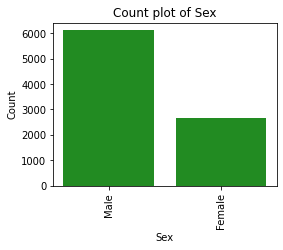

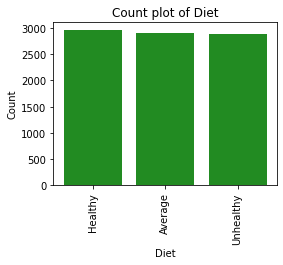

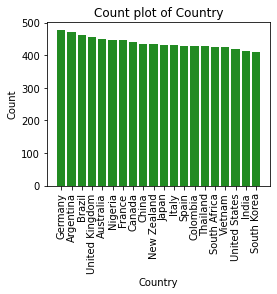

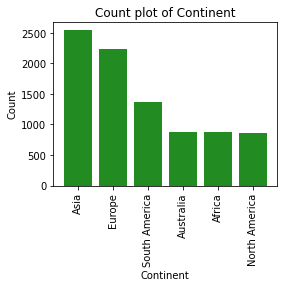

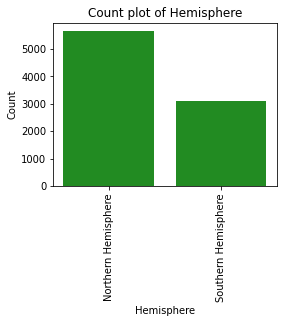

In [4]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Assuming spark session is already created as 'spark'
columns = ["Sex", "Diet", "Country", "Continent", "Hemisphere"]

for column in columns:
    # Group by the column and count occurrences
    group_data = df.groupBy(column).count()

    # Convert to Pandas DataFrame for plotting
    pandas_df = group_data.toPandas().sort_values(by='count', ascending=False)

    # Plotting using matplotlib
    plt.figure(figsize=(4, 3))
    plt.bar(pandas_df[column], pandas_df['count'], color='forestgreen')  # Changed color here
    plt.title(f"Count plot of {column}")
    plt.xticks(rotation=90)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()


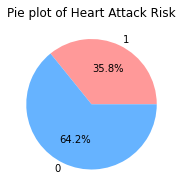

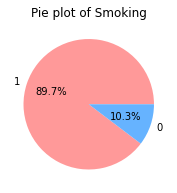

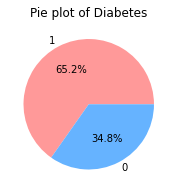

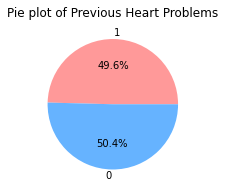

In [5]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Assuming spark session is already created as 'spark'
columns = ["Heart Attack Risk", "Smoking", "Diabetes", "Previous Heart Problems"]

for column in columns:
    # Group by the column and count occurrences
    group_data = df.groupBy(column).count()

    # Convert to Pandas DataFrame for plotting
    pandas_df = group_data.toPandas().set_index(column)

    # Plotting using matplotlib
    plt.figure(figsize=(4, 3))
    pandas_df['count'].plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])  # You can specify different colors for each segment
    plt.title(f"Pie plot of {column}")
    plt.ylabel('')  # Hide the y-label as it's not needed for pie charts
    plt.show()
    


+---+----------+--------+--------------+-------+-------+-----------+-------------------+-----------------------+-----------------------+--------------+------------+-----------------------+-----------+-------------+-------------------------------+-------------------+-----------------+
|Age|Heart Rate|Diabetes|Family History|Smoking|Obesity|Cholesterol|Alcohol Consumption|Exercise Hours Per Week|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|        BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|Heart Attack Risk|
+---+----------+--------+--------------+-------+-------+-----------+-------------------+-----------------------+-----------------------+--------------+------------+-----------------------+-----------+-------------+-------------------------------+-------------------+-----------------+
| 67|        72|       0|             0|      1|      0|        208|                  0|            4.168188835|                      0|         

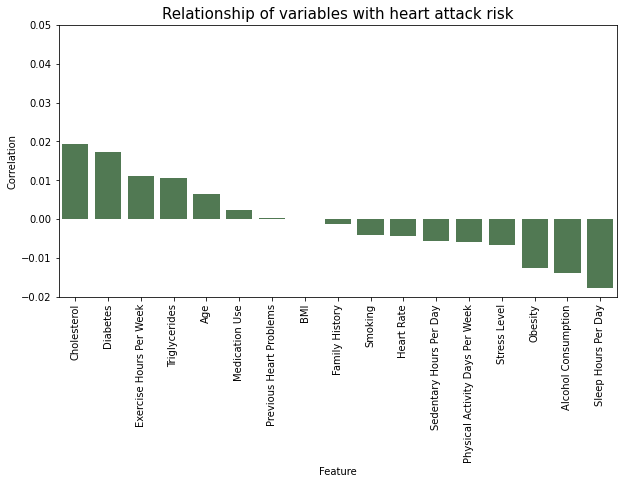

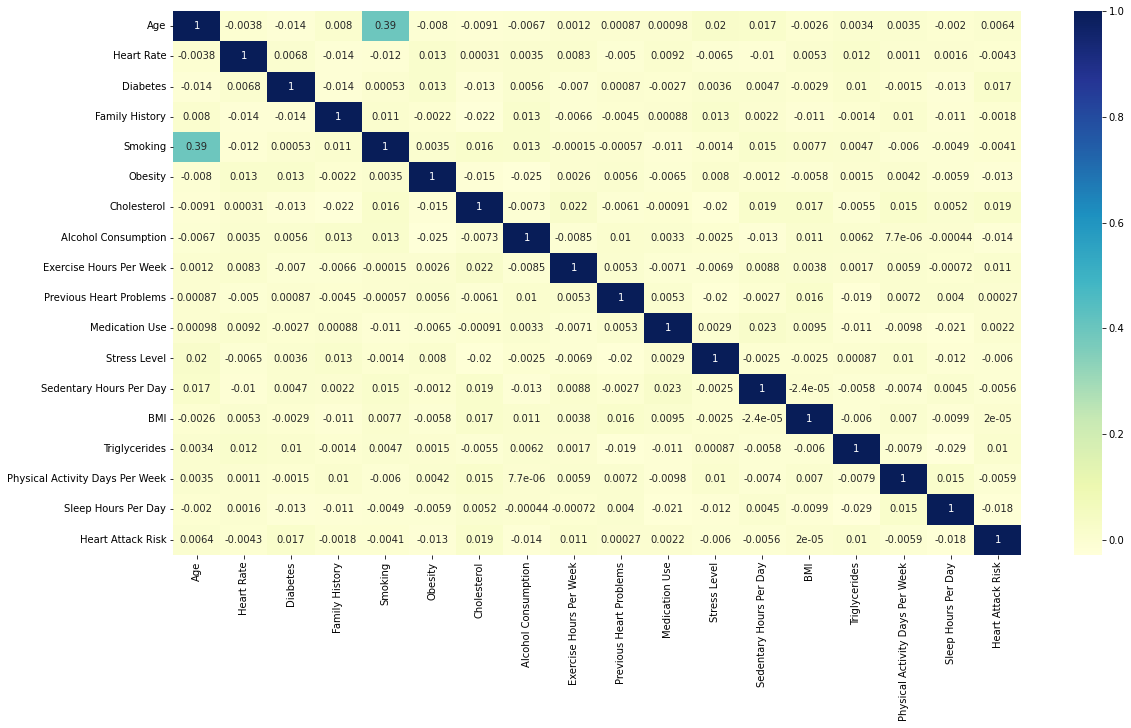

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#3.1
# Assuming df is a PySpark DataFrame already loaded
data = df.select('Age','Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
                 'Cholesterol','Alcohol Consumption', 'Exercise Hours Per Week',
                 'Previous Heart Problems', 'Medication Use', 'Stress Level',
                 'Sedentary Hours Per Day', 'BMI', 'Triglycerides',
                 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk')

# Show the first few rows and the schema of the DataFrame
data.show()
data.printSchema()

print("\n\n")

# Calculating correlations individually because PySpark does not support correlation matrices as Pandas does
# Collect the names of columns except for the target variable
feature_cols = [col_name for col_name in data.columns if col_name != 'Heart Attack Risk']

# Initialize a dictionary to hold correlation values
heart_attack_corr = {}
for col_name in feature_cols:
    corr_value = data.stat.corr("Heart Attack Risk", col_name)
    heart_attack_corr[col_name] = corr_value

# Convert dictionary to a list of tuples sorted by correlation value
sorted_corr = sorted(heart_attack_corr.items(), key=lambda x: x[1], reverse=True)

# Since PySpark doesn't support plotting directly, we convert the sorted list back to Pandas for plotting
corr_df = pd.DataFrame(sorted_corr, columns=["Feature", "Correlation"])
plt.figure(figsize=(10,5))
sns.barplot(x="Feature", y="Correlation", data=corr_df, color="#4a804d")
plt.xticks(rotation=90)
plt.ylim(-0.02, 0.05)
plt.title("Relationship of variables with heart attack risk", fontsize=15)
plt.show()

# For the correlation matrix, we will collect data to Pandas
pandas_df = data.toPandas()
plt.figure(figsize=(19,10))
sns.heatmap(pandas_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [7]:
#3.2
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import Imputer

# Specify columns to be imputed for numeric data and apply median imputation
columns_to_impute = ['Stress Level', 'Sleep Hours Per Day']
median_imputer = Imputer(strategy='median', inputCols=columns_to_impute, outputCols=[c + "_imputed" for c in columns_to_impute])
df = median_imputer.fit(df).transform(df)

# Function to calculate the mode and fill categorical columns
def impute_mode(df, column):
    mode = df.groupBy(column).count().orderBy('count', ascending=False).first()[0]
    return df.na.fill({column: mode})

# Categorical columns imputation
categorical_columns_to_impute = ['Obesity', 'Family History']
for column in categorical_columns_to_impute:
    df = impute_mode(df, column)

# Re-check null values for all imputed columns to ensure completeness of the imputation
all_imputed_columns = [c + "_imputed" for c in columns_to_impute] + categorical_columns_to_impute
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in all_imputed_columns])

print("Null values count in all imputed columns after imputation:")
null_counts.show()


Null values count in all imputed columns after imputation:
+--------------------+---------------------------+-------+--------------+
|Stress Level_imputed|Sleep Hours Per Day_imputed|Obesity|Family History|
+--------------------+---------------------------+-------+--------------+
|                   0|                          0|      0|             0|
+--------------------+---------------------------+-------+--------------+



In [8]:
#3.3
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Start a Spark session


# Assuming 'df' is a PySpark DataFrame already loaded with data
# Splitting 'Blood Pressure' into 'BP_Systolic' and 'BP_Diastolic'
df = df.withColumn("BP_Systolic", split(col("Blood Pressure"), "/").getItem(0).cast("integer"))
df = df.withColumn("BP_Diastolic", split(col("Blood Pressure"), "/").getItem(1).cast("integer"))

# Ordinal encoding for 'Diet'
ordinal_map = {'Healthy': 2, 'Average': 1, 'Unhealthy': 0}
mapping_expr = when(col("Diet") == "Healthy", ordinal_map['Healthy'])
for key, value in ordinal_map.items():
    mapping_expr = mapping_expr.when(col("Diet") == key, value)
df = df.withColumn("Diet", mapping_expr)

# One-hot encoding for 'Sex (Gender)'
sex_indexer = StringIndexer(inputCol="Sex", outputCol="Sex_Index")
sex_encoder = OneHotEncoder(inputCols=["Sex_Index"], outputCols=["Sex_OHE"])

# Define the pipeline
pipeline = Pipeline(stages=[sex_indexer, sex_encoder])

# Apply the transformations
df = pipeline.fit(df).transform(df)

# Optionally dropping the intermediate index column
df = df.drop("Sex_Index")

# Show DataFrame information
df.printSchema()
df.dtypes

root
 |-- Patient ID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History: integer (nullable = false)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = false)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Diet: integer (nullable = true)
 |-- Previous Heart Problems: integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = true)
 |-- Sleep Hours Per Day: integer (nullable = true)
 |-- Country: string (nullable = tr

[('Patient ID', 'string'),
 ('Age', 'int'),
 ('Sex', 'string'),
 ('Cholesterol', 'int'),
 ('Blood Pressure', 'string'),
 ('Heart Rate', 'int'),
 ('Diabetes', 'int'),
 ('Family History', 'int'),
 ('Smoking', 'int'),
 ('Obesity', 'int'),
 ('Alcohol Consumption', 'int'),
 ('Exercise Hours Per Week', 'double'),
 ('Diet', 'int'),
 ('Previous Heart Problems', 'int'),
 ('Medication Use', 'int'),
 ('Stress Level', 'int'),
 ('Sedentary Hours Per Day', 'double'),
 ('BMI', 'double'),
 ('Triglycerides', 'int'),
 ('Physical Activity Days Per Week', 'int'),
 ('Sleep Hours Per Day', 'int'),
 ('Country', 'string'),
 ('Continent', 'string'),
 ('Hemisphere', 'string'),
 ('Heart Attack Risk', 'int'),
 ('Stress Level_imputed', 'int'),
 ('Sleep Hours Per Day_imputed', 'int'),
 ('BP_Systolic', 'int'),
 ('BP_Diastolic', 'int'),
 ('Sex_OHE', 'vector')]

In [9]:
#3.4 
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder.appName("Data Merging").getOrCreate()

# Assuming 'df' is a PySpark DataFrame already loaded with data
# Load the second DataFrame
df2 = spark.read.csv("./Dataset/Income.csv", header=True, inferSchema=True)

# Merge the DataFrames on 'Patient ID' column
merged_data = df.join(df2, on="Patient ID", how="inner")

# Display the merged data
merged_data.show()
merged_data.printSchema()

merged_data.dtypes


24/05/23 05:52:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+---+------+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+----+-----------------------+--------------+------------+-----------------------+-----------+-------------+-------------------------------+-------------------+-------------+-------------+-------------------+-----------------+--------------------+---------------------------+-----------+------------+-------------+------+
|Patient ID|Age|   Sex|Cholesterol|Blood Pressure|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|        BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|      Country|    Continent|         Hemisphere|Heart Attack Risk|Stress Level_imputed|Sleep Hours Per Day_imputed|BP_Systolic|BP_Diastolic|      Sex_OHE|Income|
+----------+---+------+-----------+--------------+----------+-------

root
 |-- Patient ID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History: integer (nullable = false)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = false)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Diet: integer (nullable = true)
 |-- Previous Heart Problems: integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = true)
 |-- Sleep Hours Per Day: integer (nullable = true)
 |-- Country: string (nullable = tr

[('Patient ID', 'string'),
 ('Age', 'int'),
 ('Sex', 'string'),
 ('Cholesterol', 'int'),
 ('Blood Pressure', 'string'),
 ('Heart Rate', 'int'),
 ('Diabetes', 'int'),
 ('Family History', 'int'),
 ('Smoking', 'int'),
 ('Obesity', 'int'),
 ('Alcohol Consumption', 'int'),
 ('Exercise Hours Per Week', 'double'),
 ('Diet', 'int'),
 ('Previous Heart Problems', 'int'),
 ('Medication Use', 'int'),
 ('Stress Level', 'int'),
 ('Sedentary Hours Per Day', 'double'),
 ('BMI', 'double'),
 ('Triglycerides', 'int'),
 ('Physical Activity Days Per Week', 'int'),
 ('Sleep Hours Per Day', 'int'),
 ('Country', 'string'),
 ('Continent', 'string'),
 ('Hemisphere', 'string'),
 ('Heart Attack Risk', 'int'),
 ('Stress Level_imputed', 'int'),
 ('Sleep Hours Per Day_imputed', 'int'),
 ('BP_Systolic', 'int'),
 ('BP_Diastolic', 'int'),
 ('Sex_OHE', 'vector'),
 ('Income', 'int')]